# Load Packages

In [1]:
using Dates, Roots

include("printmat.jl")
include("printTable.jl")

printmatDate (generic function with 8 methods)

In [3]:
using Plots
backend = "gr"              #"gr" (default), "pyplot" 

if backend == "pyplot"
    pyplot(size=(600,400))
else    
    gr(size=(480,320))
    default(fmt = :svg)
end

### From Chapter on Bonds 1

In [4]:
"""
Y:  scalar or K vector of interest rates
cf: scalar or K vector of cash flows
m: K vector of times of cash flows
"""
function BondPrice3(Y,cf,m)                #cf is a vector of all cash flows
    cdisc = cf./((Y.+1).^m)                #c/(1+y1)^t1 + c/(1+y2)^t2 + ...+ c/(1+y2)^m
    P     = sum(cdisc)                     #price
    return P
end

BondPrice3 (generic function with 1 method)

# Value of a Liability after a Sudden Interest Rate Change

The calculations below assume that the yield curve is flat, but that it can shift up or down. This assumption helps us connect to the classical literature on duration hedging.

The initial values are indicated by subscript $_0$ and the values after the interest rate change by the subscript $_1$. It is assumed that the change is very sudden, so the time to cash flows are (virtually) the same before and after.

The next cell sets up the cash flow for a liability that pays 0.2 each year for the next 10 years. The value of the liability is calculated at an initial interest rate ($\theta_0$) and at a new interest rate ($\theta_1$).

In [5]:
θ₀ = 0.05                   #initial interest rate
θ₁ = 0.03                   #interest rate after sudden change

cf = fill(0.2,10)           #cash flow of liability
m  = 1:10                   #time periods of the cash flows

P₀ = BondPrice3(θ₀,cf,m)     
P₁ = BondPrice3(θ₁,cf,m)     
R = (P₁ - P₀)/P₀

println("As θ changes from θ₀=$θ₀ to θ₁=$θ₁: ")
xy = [P₀, P₁, R]
printTable(xy,[" "],["P₀";"P₁";"ΔP/P₀"],15)

println("Notice that the liability is worth more at the lower interest rate")

As θ changes from θ₀=0.05 to θ₁=0.03: 
                    
P₀             1.544
P₁             1.706
ΔP/P₀          0.105

Notice that the liability is worth more at the lower interest rate


# Macaulay's Duration

$D^M = \sum_{k=1}^{K} m_{k}\frac{cf_{k}}{\left(  1+\theta\right)  ^{m_{k}}P}$

A first-order Taylor approximation gives

$\frac{\Delta P}{P} = -D^M \times \frac{\Delta \theta}{1+\theta}$ 

In [6]:
"""
    BondDuration(P,cf,m,ytm)

Caclulate Macaulays (bond) duration measure.

P:   scalar, bond price
cf:  scalar or K vector of cash flows
m:   K vector of times of cash flows
ytm: scalar, yield to maturity
"""
function BondDuration(P,cf,m,ytm)
    cdisc   = cf.*m./((1+ytm).^(m.+1))      #c/(1+y)^2 + 2c/(1+y)^3 + ...
    D       = sum(cdisc)                    #Duration, row vector
    Da      = D/P                           #adjusted duration
    Dmac    = D*(1+ytm)/P                   #Macaulays duration
    return Dmac
end

BondDuration (generic function with 1 method)

In [7]:
Dmac    = BondDuration(P₀,cf,m,θ₀)

printlnPs("Macaulay's duration ",Dmac)

Δθ       = θ₁ - θ₀
R_approx = -Dmac*Δθ/(1+θ₀)

println("\nExact and approximate relative price change (as the interest changes): ")
printlnPs([R R_approx])

Macaulay's duration      5.099

Exact and approximate relative price change (as the interest changes): 
     0.105     0.097


# Hedging a Liability Stream

We are short one $L$ bond, which is worth $P_L$. To hedge that we buy $h$ units of bond $H$. The balance is put on a money market account $M$ to make the initial value of the portfolio zero ($V=0$)

$V=hP_{H}+M-P_{L}$

Over a short time interval, the change in the portfolio value is

$\Delta V=h\Delta P_{H}-\Delta P_{L}$.

In the cells below, we assume that the yield curve is flat, so $\theta_{H} = \theta_{L}$ both before and after the change.

In [8]:
PL₀ = P₀        #just switching notation: this is the value of the liability
PL₁ = P₁        

printlnPs("Value of liability at interest rates $θ₀ and $θ₁: ",[PL₀ PL₁])

printlnPs("\nMacaulay's duration of the liability: ",Dmac)

Value of liability at interest rates 0.05 and 0.03:      1.544     1.706

Macaulay's duration of the liability:      5.099


## Duration Matching

Choose a hedge bond with the same duration as the liability and invest equally much into each.

This is a special case of the naive hedging where $D_{L}^{M}=D_{H}$. Clearly, this gives $\frac{\Delta V}{P_{L}}\approx 0$.

In [9]:
printlnPs("Hedge bond: a zero coupon bond with m=$(round(Dmac,digits=2)) and face value of 1")

PH₀ = BondPrice3(θ₀,1,Dmac)       
PH₁ = BondPrice3(θ₁,1,Dmac)      
h = PL₀/PH₀

ΔV = h*(PH₁-PH₀) - (PL₁-PL₀)
R  = ΔV/PL₀

xy = [PL₀;PH₀;h;Dmac;Dmac;R]
printTable(xy,[" "],["PL₀";"PH₀";"h";"Dur(liability)";"Dur(hedge)";"Return"])

println("Notice, the duration matching gives return of $(round(R*100,digits=1))%. Close to zero.")

Hedge bond: a zero coupon bond with m=5.1 and face value of 1
                        
PL₀                1.544
PH₀                0.780
h                  1.981
Dur(liability)     5.099
Dur(hedge)         5.099
Return            -0.002

Notice, the duration matching gives return of -0.2%. Close to zero.


## Naive Hedging

The "naive" hedging invests the same amount in the hedge bond as the value of the liability, that is, $hP_{H}=P_{L}$ so $h=P_{L}/P_{H}$. This means that the money market account is not used ($M=0$).

It can be shown that

$\frac{\Delta V}{P_{L}}\approx\left(  D_{L}^{M}-D_{H}^{M}\right)  \times
\frac{\Delta\theta}{1+\theta}$.

If $D_{L}>D_{H}$, and $\Delta\theta<0$ (as in the example below), then we will lose money.

In [10]:
mH = 3                     #mH year bill is used as hedge bond

printlnPs("Hedge bond: zero coupon bond with m=$mH and face value of 1")

PH₀ = BondPrice3(θ₀,1,mH)             
PH₁ = BondPrice3(θ₁,1,mH)      

h = PL₀/PH₀

ΔV = h*(PH₁-PH₀) - (PL₁-PL₀)
R  = ΔV/PL₀

xy = [PL₀;PH₀;h;Dmac;mH;R]
printTable(xy,[" "],["PL₀";"PH₀";"h";"Dur(liability)";"Dur(hedge)";"Return"])

println("Notice, the naive hedge gives a return of $(round(R*100,digits=1))%")

Hedge bond: zero coupon bond with m=3 and face value of 1
                        
PL₀                1.544
PH₀                0.864
h                  1.788
Dur(liability)     5.099
Dur(hedge)         3.000
Return            -0.045

Notice, the naive hedge gives a return of -4.5%


## Illustrating the Problem with the Naive Hedging

by plotting the value of the liability ($P_L$) and of the hedge bond position ($hP_H$) at different interest rates.

In [11]:
θ = 0:0.01:0.1

(PL,PH) = (fill(NaN,length(θ)),fill(NaN,length(θ)))
for i = 1:length(θ)
    PL[i] = BondPrice3(θ[i],cf,m)  
    PH[i] = BondPrice3(θ[i],1,mH)
end

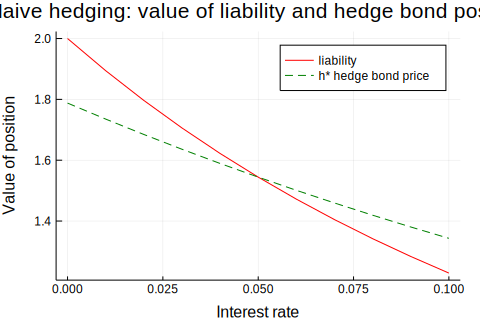

In [12]:
p1 = plot(θ,PL,color=:red,label="liability")
plot!(θ,h*PH,color=:green,line=:dash,label="h* hedge bond price   ")
title!("Naive hedging: value of liability and hedge bond position")
xlabel!("Interest rate")
ylabel!("Value of position")
annotate!(0.02,350,"The interest rates are\n $θ₀ (before) and $θ₁ (after)")

## Duration Hedging

In this case, $D_{L}^{M}\neq D_{H}$, but we adjust the hedge ratio $h$ to compensate for that. In particular, set 

$h =\frac{D_{L}^{M}}{D_{H}^{M}}\times\frac{P_{L}}{P_{H}}$. 

The balance $(P_L-hP_H)$ is kept on a money market account ($M$).

It can be shown that this gives an (approximate) hedge.

In [13]:
printlnPs("Hedge bond: zero coupon bond with m=$mH and face value of 1")

PH₀ = BondPrice3(θ₀,1,mH)             
PH₁ = BondPrice3(θ₁,1,mH)      
h = Dmac/mH * PL₀/PH₀
M = PL₀ - h*PH₀               #on money market account

ΔV = h*(PH₁-PH₀) - (PL₁-PL₀)
R  = ΔV/PL₀

xy = [PL₀;PH₀;h;Dmac;mH;M;R]
printTable(xy,[" "],["PL₀";"PH₀";"h";"Dur(liability)";"Dur(hedge)";"M";"Return"])

println("Notice, the duration hedging gives return of $(round(R*100,digits=1))%. Close to zero.")

Hedge bond: zero coupon bond with m=3 and face value of 1
                        
PL₀                1.544
PH₀                0.864
h                  3.039
Dur(liability)     5.099
Dur(hedge)         3.000
M                 -1.081
Return            -0.004

Notice, the duration hedging gives return of -0.4%. Close to zero.


## Convexity (extra)

A second-order Taylor approximation gives that 

$
\frac{\Delta P}{P}\approx-D^{M}\times\frac{\Delta\theta}{1+\theta}+\frac{1}{2}C\times(\Delta\theta)^{2}, 
$

where 
$
C = \frac{1}{P} \frac{d^{2}P}{d\theta^{2}}
$. 

The function below calculates $C$.

In [14]:
function BondConvexity(P,cf,m,ytm)
    cdisc   = cf.*m.*(m.+1)./((1+ytm).^(m.+2)) 
    C       = sum(cdisc)/P                    #Duration, row vector
    return C
end

BondConvexity (generic function with 1 method)

In [15]:
C = BondConvexity(P₀,cf,m,θ₀)

printlnPs("C=",C," and the total 2nd term is ",0.5*C*Δθ^2)

C=    35.602 and the total 2nd term is      0.007
